# Setup

In [1]:
import copy
from functools import partial
from pathlib import Path
from typing import Optional

from IPython.display import Image, display
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

In [2]:
mps_available = torch.backends.mps.is_available()
mps_available

True

In [3]:
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seeds()

In [4]:
# Model Configuration
RANK = 4  # LoRA/DoRA rank
ALPHA = 8  # LoRA/DoRA scaling factor
NUM_HIDDEN_1 = 20
NUM_HIDDEN_2 = 20

# Training Configuration
LEARNING_RATE = 0.01
NUM_STEPS = 150

# Animation Configuration
INTERVAL = 20
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Data Configuration
NUM_SAMPLES = 100
NOISE_SCALE = 0.1

In [5]:
torch.__version__

'2.5.1'

In [6]:
def get_device() -> torch.device:
    """Determine the best available device for PyTorch."""
    if torch.cuda.is_available():
        print("Using CUDA device")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using MPS device")
        return torch.device("mps")
    else:
        print("Using CPU device")
        return torch.device("cpu")


DEVICE = get_device()
DEVICE

Using MPS device


device(type='mps')

# Generate Data

In [7]:
def generate_data(
    num_samples: int = NUM_SAMPLES,
    noise_scale: float = NOISE_SCALE,
    device: Optional[torch.device] = None,
) -> tuple[Tensor, Tensor, Tensor]:
    """Generate synthetic data for training.

    Args:
        num_samples: Number of data points to generate
        noise_scale: Scale of random noise to add
        device: Device to place tensors on

    Returns:
        x: Input tensor
        y1: First target tensor
        y2: Second target tensor
    """
    if device is None:
        device = get_device()

    try:
        x = torch.linspace(-1, 1, num_samples)[:, None].to(device)
        noise = torch.randn(num_samples)[:, None].to(device)

        y1 = x**2 + noise_scale * noise
        y2 = (
            x**3
            - 0.5 * x**2
            + 0.5
            + noise_scale * torch.randn(num_samples)[:, None].to(device)
        )

        return x, y1, y2
    except RuntimeError as e:
        print(f"Error generating data: {e}")
        raise


# Replace current data generation with:
x, y1, y2 = generate_data(device=DEVICE)

# Train Base Model

In [8]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, device=None):
        super().__init__()
        if device is None:
            device = get_device()

        self.layers = nn.Sequential(
            nn.Linear(num_features, num_hidden_1),
            nn.ReLU(),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.ReLU(),
            nn.Linear(num_hidden_2, 1),
        ).to(device)

    def forward(self, x):
        return self.layers(x)

In [9]:
model = MultilayerPerceptron(1, NUM_HIDDEN_1, NUM_HIDDEN_2).to(DEVICE)
model

Using MPS device


MultilayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [10]:
def create_training_plot(x, y1, y2, model_output):
    """Create a scatter plot of the data points and model prediction line.

    Args:
        x: Input tensor
        y1: First dataset tensor
        y2: Second dataset tensor
        model_output: Model predictions tensor

    Returns:
        fig: matplotlib figure
        line: Line artist for model predictions
    """
    x_cpu = x.cpu()
    y1_cpu = y1.cpu()
    y2_cpu = y2.cpu()
    output_cpu = model_output.cpu().detach()

    fig = plt.figure()
    plt.scatter(x_cpu, y1_cpu, label="Dataset 1")
    plt.scatter(x_cpu, y2_cpu, label="Dataset 2")
    (line,) = plt.plot(x_cpu, output_cpu, "r-", label="Model Prediction")
    plt.legend()
    return fig, line


def animate(model, y, optimizer, line, frame):
    """Animate one frame of training.

    Args:
        model: PyTorch model to train
        y: Target tensor
        optimizer: PyTorch optimizer
        line: Line artist to update
        frame: Current frame number
    """
    # FuncAnimation calls frame=0 twice at start, we want to show initial state both times
    if frame == 0:
        line.set_ydata(model(x).cpu().detach().numpy())
        print(f"Initial Loss: {nn.MSELoss()(model(x), y):.4f}")
        return (line,)

    loss = update(model, y, optimizer)
    if frame % 10 == 0:
        print(f"Iteration {frame}, Loss: {loss:.4f}")

    line.set_ydata(model(x).cpu().detach().numpy())
    return (line,)


def update(model, y, optimizer, loss_fn=nn.MSELoss()):
    """Perform one training step."""
    optimizer.zero_grad()
    try:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    except RuntimeError as e:
        print(f"Error during training step: {e}")
        raise


def create_training_animation(
    model, x, y, optimizer, save_path: str, NUM_STEPS=NUM_STEPS, interval=INTERVAL
):
    """Create an animation of the training process and save it as a GIF.

    Args:
        model: PyTorch model to train
        x: Input tensor
        y: Target tensor
        optimizer: PyTorch optimizer
        save_path: Path where to save the GIF
        NUM_STEPS: Number of training steps to animate
        interval: Milliseconds between animation frames
    """
    fig, line = create_training_plot(x, y1, y2, model(x))
    plt.close()  # Prevent display of initial figure

    anim = animation.FuncAnimation(
        fig,
        partial(animate, model, y, optimizer, line),
        frames=NUM_STEPS,
        repeat=False,
        interval=interval,
    )

    anim.save(save_path, writer="pillow")
    plt.close()
    display(Image(filename=save_path))

    return anim

Initial Loss: 0.0076
Initial Loss: 0.0076
Iteration 10, Loss: 0.0077
Iteration 20, Loss: 0.0078
Iteration 30, Loss: 0.0077
Iteration 40, Loss: 0.0075
Iteration 50, Loss: 0.0074
Iteration 60, Loss: 0.0074
Iteration 70, Loss: 0.0073
Iteration 80, Loss: 0.0073
Iteration 90, Loss: 0.0073
Iteration 100, Loss: 0.0073
Iteration 110, Loss: 0.0073
Iteration 120, Loss: 0.0072
Iteration 130, Loss: 0.0072
Iteration 140, Loss: 0.0072


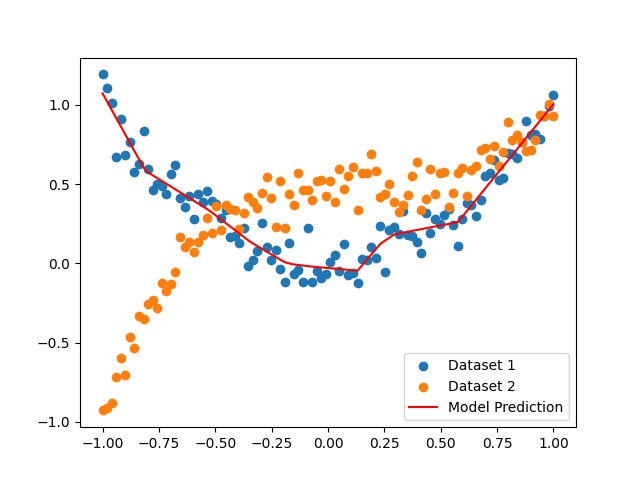

Initial Loss: 0.0072
Initial Loss: 0.0072
Iteration 10, Loss: 0.0072
Iteration 20, Loss: 0.0072
Iteration 30, Loss: 0.0072
Iteration 40, Loss: 0.0072
Iteration 50, Loss: 0.0072
Iteration 60, Loss: 0.0072
Iteration 70, Loss: 0.0072
Iteration 80, Loss: 0.0072
Iteration 90, Loss: 0.0072
Iteration 100, Loss: 0.0072
Iteration 110, Loss: 0.0072
Iteration 120, Loss: 0.0072
Iteration 130, Loss: 0.0072
Iteration 140, Loss: 0.0072


In [15]:
rc('animation', html='jshtml')

anim =create_training_animation(
    model,
    x,
    y1,
    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    save_path=OUTPUT_DIR / "base_model.gif",
)

from IPython.display import HTML
HTML(anim.to_html5_video())

[GIF](output/base_model.gif)

# Standard Fine-Tuning

In [12]:
finetune_model = copy.deepcopy(model)

Initial Loss: 0.3533
Initial Loss: 0.3533
Iteration 10, Loss: 0.0699
Iteration 20, Loss: 0.0476
Iteration 30, Loss: 0.0357
Iteration 40, Loss: 0.0283
Iteration 50, Loss: 0.0235
Iteration 60, Loss: 0.0193
Iteration 70, Loss: 0.0154
Iteration 80, Loss: 0.0122
Iteration 90, Loss: 0.0102
Iteration 100, Loss: 0.0090
Iteration 110, Loss: 0.0085
Iteration 120, Loss: 0.0082
Iteration 130, Loss: 0.0079
Iteration 140, Loss: 0.0077


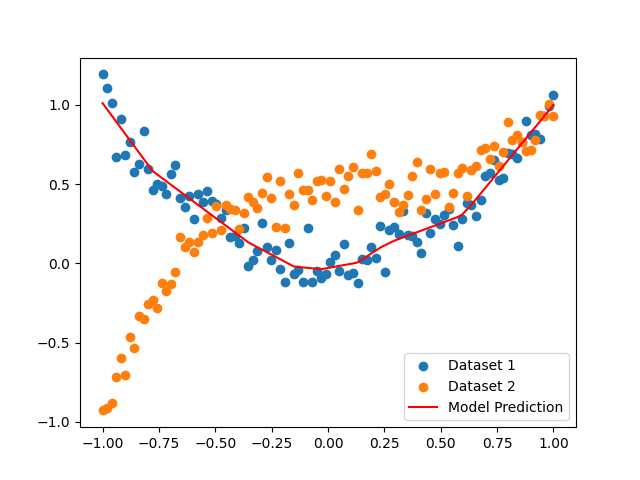

In [ ]:
create_training_animation(
    finetune_model,
    x,
    y2,
    torch.optim.Adam(finetune_model.parameters(), lr=LEARNING_RATE),
    save_path=OUTPUT_DIR / "finetune_model.gif",
)

[GIF](output/finetune_model.gif)

# LoRA Fine-Tuning

In [14]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, rank: int, alpha: float) -> None:
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x: Tensor) -> Tensor:
        return self.alpha * (x @ self.A @ self.B)

In [15]:
class LinearWithLoRA(nn.Module):
    def __init__(self, linear: nn.Linear, rank: int, alpha: float) -> None:
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x) + self.lora(x)

In [16]:
def test_lora_layer_does_not_change_initial_output():
    layer = nn.Linear(1, 2).to(DEVICE)
    original_output = layer(x[0])
    layer_lora = LinearWithLoRA(layer, rank=1, alpha=4).to(DEVICE)
    lora_output = layer_lora(x[0])
    assert (lora_output == original_output).all()


test_lora_layer_does_not_change_initial_output()

In [17]:
class LinearWithLoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        combined_weight = self.linear.weight + self.lora.alpha * lora.T
        return F.linear(x, combined_weight, self.linear.bias)

In [18]:
def test_lora_merged_layer_does_not_change_initial_output():
    layer = nn.Linear(1, 2).to(DEVICE)
    original_output = layer(x[0])
    layer_lora = LinearWithLoRAMerged(layer, rank=1, alpha=4).to(DEVICE)
    lora_output = layer_lora(x[0])
    assert (lora_output == original_output).all()


test_lora_merged_layer_does_not_change_initial_output()

In [19]:
lora_model = copy.deepcopy(model)
torch.manual_seed(
    678
)  # resetting seed so LoRA and LoRAMerged get the same LoRA weight initializations
lora_model.layers[0] = LinearWithLoRA(lora_model.layers[0], rank=RANK, alpha=ALPHA).to(
    DEVICE
)
lora_model.layers[2] = LinearWithLoRA(lora_model.layers[2], rank=RANK, alpha=ALPHA).to(
    DEVICE
)
lora_model.layers[4] = LinearWithLoRA(lora_model.layers[4], rank=RANK, alpha=ALPHA).to(
    DEVICE
)

lora_model_merged = copy.deepcopy(model)
torch.manual_seed(
    678
)  # resetting seed so LoRA and LoRAMerged get the same LoRA weight initializations
lora_model_merged.layers[0] = LinearWithLoRAMerged(
    lora_model_merged.layers[0], rank=RANK, alpha=ALPHA
).to(DEVICE)
lora_model_merged.layers[2] = LinearWithLoRAMerged(
    lora_model_merged.layers[2], rank=RANK, alpha=ALPHA
).to(DEVICE)
lora_model_merged.layers[4] = LinearWithLoRAMerged(
    lora_model_merged.layers[4], rank=RANK, alpha=ALPHA
).to(DEVICE)

In [20]:
lora_model

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithLoRA(
      (linear): Linear(in_features=1, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithLoRA(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithLoRA(
      (linear): Linear(in_features=20, out_features=1, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [21]:
lora_model_merged

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithLoRAMerged(
      (linear): Linear(in_features=1, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithLoRAMerged(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithLoRAMerged(
      (linear): Linear(in_features=20, out_features=1, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [22]:
lora_model_merged

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithLoRAMerged(
      (linear): Linear(in_features=1, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithLoRAMerged(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithLoRAMerged(
      (linear): Linear(in_features=20, out_features=1, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [23]:
def freeze_linear_layers(model):
    for child in model.children():
        if isinstance(child, nn.Linear):
            for param in child.parameters():
                param.requires_grad = False
        else:
            freeze_linear_layers(child)


freeze_linear_layers(lora_model)
print("Confirming LoRA model linear layers are frozen")
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")

print()

freeze_linear_layers(lora_model_merged)
print("Confirming LoRA Merged model linear layers are frozen")
for name, param in lora_model_merged.named_parameters():
    print(f"{name}: {param.requires_grad}")

Confirming LoRA model linear layers are frozen
layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True

Confirming LoRA Merged model linear layers are frozen
layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True


In [24]:
def test_lora_models_produce_same_output():
    with torch.no_grad():
        output1 = lora_model(x)
        output2 = lora_model_merged(x)
        diff = (output1 - output2).abs().max().item()
        assert diff < 1e-5


test_lora_models_produce_same_output()

Initial Loss: 0.3533
Initial Loss: 0.3533
Iteration 10, Loss: 0.0683
Iteration 20, Loss: 0.0441
Iteration 30, Loss: 0.0228
Iteration 40, Loss: 0.0129
Iteration 50, Loss: 0.0095
Iteration 60, Loss: 0.0080
Iteration 70, Loss: 0.0076
Iteration 80, Loss: 0.0074
Iteration 90, Loss: 0.0073
Iteration 100, Loss: 0.0073
Iteration 110, Loss: 0.0072
Iteration 120, Loss: 0.0072
Iteration 130, Loss: 0.0071
Iteration 140, Loss: 0.0071


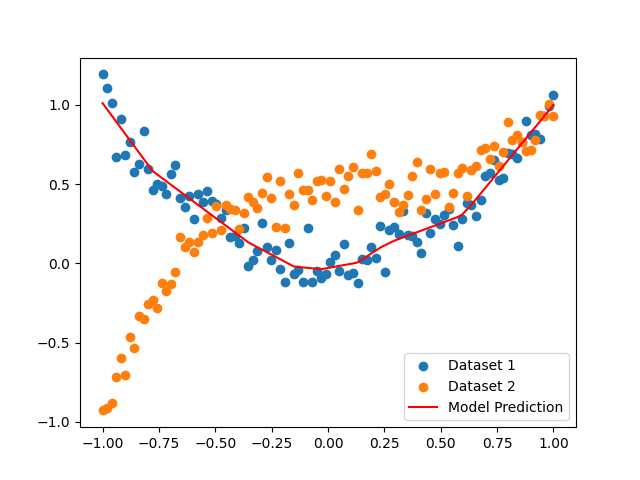

In [ ]:
create_training_animation(
    lora_model,
    x,
    y2,
    torch.optim.Adam(lora_model.parameters(), lr=LEARNING_RATE),
    save_path=OUTPUT_DIR / "lora_model.gif",
)

[GIF](output/lora_model.gif)

Initial Loss: 0.3533
Initial Loss: 0.3533
Iteration 10, Loss: 0.0683
Iteration 20, Loss: 0.0441
Iteration 30, Loss: 0.0228
Iteration 40, Loss: 0.0129
Iteration 50, Loss: 0.0095
Iteration 60, Loss: 0.0080
Iteration 70, Loss: 0.0076
Iteration 80, Loss: 0.0074
Iteration 90, Loss: 0.0073
Iteration 100, Loss: 0.0073
Iteration 110, Loss: 0.0072
Iteration 120, Loss: 0.0072
Iteration 130, Loss: 0.0071
Iteration 140, Loss: 0.0071


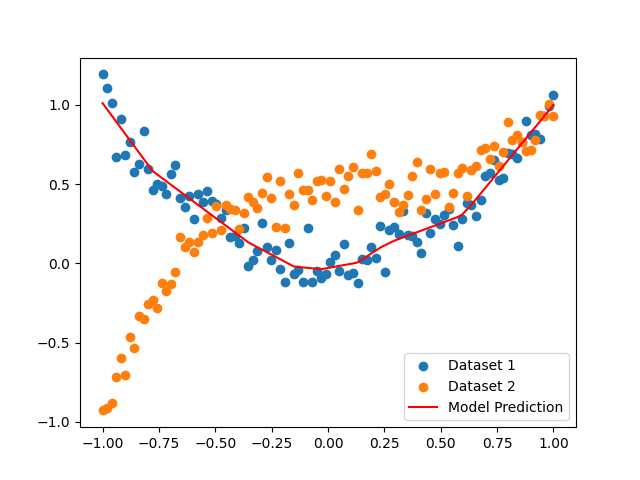

In [ ]:
create_training_animation(
    lora_model_merged,
    x,
    y2,
    torch.optim.Adam(lora_model_merged.parameters(), lr=LEARNING_RATE),
    save_path=OUTPUT_DIR / "lora_model_merged.gif",
)

[GIF](output/lora_model_merged.gif)

# DoRA Fine-Tuning

In [27]:
class LinearWithDoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
        self.m = nn.Parameter(self.linear.weight.norm(p=2, dim=0, keepdim=True))

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        numerator = self.linear.weight + self.lora.alpha * lora.T
        denominator = numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = numerator / denominator
        new_weight = self.m * directional_component
        return F.linear(x, new_weight, self.linear.bias)

In [ ]:
dora_model = copy.deepcopy(model)
dora_model.layers[0] = LinearWithDoRAMerged(
    dora_model.layers[0], rank=RANK, alpha=ALPHA
).to(DEVICE)
dora_model.layers[2] = LinearWithDoRAMerged(
    dora_model.layers[2], rank=RANK, alpha=ALPHA
).to(DEVICE)
dora_model.layers[4] = LinearWithDoRAMerged(
    dora_model.layers[4], rank=RANK, alpha=ALPHA
).to(DEVICE)

print(dora_model)

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithDoRAMerged(
      (linear): Linear(in_features=1, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithDoRAMerged(
      (linear): Linear(in_features=20, out_features=20, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithDoRAMerged(
      (linear): Linear(in_features=20, out_features=1, bias=True)
      (lora): LoRALayer()
    )
  )
)


In [29]:
freeze_linear_layers(dora_model)
for name, param in dora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")

layers.0.m: True
layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.m: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.m: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True


Initial Loss: 0.3533
Initial Loss: 0.3533
Iteration 10, Loss: 0.0548
Iteration 20, Loss: 0.0379
Iteration 30, Loss: 0.0654
Iteration 40, Loss: 0.0348
Iteration 50, Loss: 0.0225
Iteration 60, Loss: 0.0139
Iteration 70, Loss: 0.0097
Iteration 80, Loss: 0.0087
Iteration 90, Loss: 0.0083
Iteration 100, Loss: 0.0078
Iteration 110, Loss: 0.0075
Iteration 120, Loss: 0.0074
Iteration 130, Loss: 0.0072
Iteration 140, Loss: 0.0071


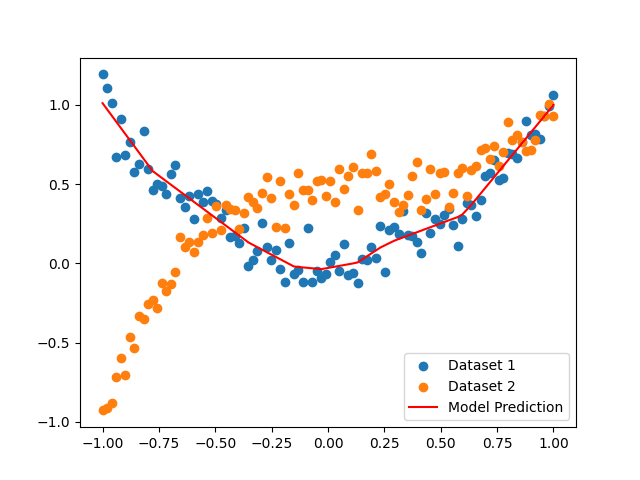

In [ ]:
create_training_animation(
    dora_model,
    x,
    y2,
    torch.optim.Adam(dora_model.parameters(), lr=LEARNING_RATE),
    save_path=OUTPUT_DIR / "dora_model.gif",
)

[GIF](output/dora_model.gif)